# MEM: GIMME

## Visualisation of the tissue-specific model

### Plotting metabolic tasks 

In this notebook, the list of metabolic tasks on existing mammalian genome-scale models obtained from Richelle et al. (2019) is tested on the tissue-specific *Salmo salar*-model extracted by using the GIMME MEM.

In [1]:
import os
os.chdir('../../salmote')

from custom_tests.test_custom_tests import *
import cobra

os.chdir('../msc-hm')

In [2]:
sasa_GIMME = cobra.io.load_matlab_model('tissue_models/matlab_models/GIMME_model.mat')
sasa_GIMME

Using license file /Users/Haavard/gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-02


<Model GIMME_model at 0x110493fd0>

In [3]:
tasksheet = 'Tasks.xlsx'
tasks = parseTaskSheet(tasksheet)

In [4]:
table = str.maketrans({'[': '_', ']': ''})
for task in tasks:
    task.insert(11, 'EQU', 0)
    for ind, row in task.iterrows():
        if row.IN:
            task.at[ind,'IN'] = row.IN.translate(table)
        if row.OUT:
            task.at[ind,'OUT'] = row.OUT.translate(table)

#### Run tasks

In [5]:
sc = score_chart(sasa_GIMME, tasks)

cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


In [6]:
sc

Description  \
1.0    Oxidative phosphorylation via NADH-coenzyme Q ...   
2.0    Oxidative phosphorylation via succinate-coenzy...   
3.0    Krebs cycle - oxidative decarboxylation of pyr...   
4.0                        Krebs cycle - NADH generation   
5.0    ATP regeneration from glucose (normoxic condit...   
...                                                  ...   
206.0  Biosynthesis of Tn_antigen (Glycoprotein N-ace...   
207.0  Keratan sulfate biosynthesis from O-glycan (co...   
208.0  Keratan sulfate biosynthesis from O-glycan (co...   
209.0                        Keratan sulfate degradation   
210.0         Keratan sulfate biosynthesis from N-glycan   

                                        Result  
1.0       <Solution infeasible at 0x128106ee0>  
2.0            <Solution 0.000 at 0x12815c940>  
3.0            <Solution 0.000 at 0x1281571f0>  
4.0            <Solution 0.000 at 0x12823bdf0>  
5.0            <Solution 0.000 at 0x12823ed90>  
...                                        ...  
206.0     Input metabolite missing: Ser__Thr_g  
207.0        Input metabolite missing: core2_g  
208.0        Input metabolite missing: core4_g  
209.0          Input metabolite missing: ksi_l  
210.0  Input metabolite missing: l2fn2m2masn_g  

[210 rows x 2 columns]

#### Collect results in dict  
Where the name of the model is the key, and the score chart is the value.

In [7]:
sd = {'model': sc}
sd

{'model':                                              Description  \
 1.0    Oxidative phosphorylation via NADH-coenzyme Q ...   
 2.0    Oxidative phosphorylation via succinate-coenzy...   
 3.0    Krebs cycle - oxidative decarboxylation of pyr...   
 4.0                        Krebs cycle - NADH generation   
 5.0    ATP regeneration from glucose (normoxic condit...   
 ...                                                  ...   
 206.0  Biosynthesis of Tn_antigen (Glycoprotein N-ace...   
 207.0  Keratan sulfate biosynthesis from O-glycan (co...   
 208.0  Keratan sulfate biosynthesis from O-glycan (co...   
 209.0                        Keratan sulfate degradation   
 210.0         Keratan sulfate biosynthesis from N-glycan   
 
                                         Result  
 1.0       <Solution infeasible at 0x128106ee0>  
 2.0            <Solution 0.000 at 0x12815c940>  
 3.0            <Solution 0.000 at 0x1281571f0>  
 4.0            <Solution 0.000 at 0x12823bdf0>  
 5.0   

#### Which rows should fail?
Score charts are scored in a dict where the keys are names/commits associated with the model. 
These names will be displayed on the x-axis.  
In addition, the tasks supposed to fail will be framed by a black rectangle.

In [8]:
should_fail = [task['SHOULD FAIL'].iloc[0] for task in tasks]
sf = [index for index in range(len(should_fail)) if should_fail[index] == 1.0]

In [9]:
sf

[6, 81, 98, 102, 105, 107, 110, 114, 122, 130, 132, 140, 146, 171, 173]

#### Combine the results to one dataframe with the task-description as index and key as column names.

In [10]:
chart = combine_charts(sd)
chart

model
Description                                                                                
Oxidative phosphorylation via NADH-coenzyme Q o...     <Solution infeasible at 0x128106ee0>
Oxidative phosphorylation via succinate-coenzym...          <Solution 0.000 at 0x12815c940>
Krebs cycle - oxidative decarboxylation of pyru...          <Solution 0.000 at 0x1281571f0>
Krebs cycle - NADH generation                               <Solution 0.000 at 0x12823bdf0>
ATP regeneration from glucose (normoxic conditi...          <Solution 0.000 at 0x12823ed90>
...                                                                                     ...
Biosynthesis of Tn_antigen (Glycoprotein N-acet...     Input metabolite missing: Ser__Thr_g
Keratan sulfate biosynthesis from O-glycan (cor...        Input metabolite missing: core2_g
Keratan sulfate biosynthesis from O-glycan (cor...        Input metabolite missing: core4_g
Keratan sulfate degradation                                 Input metabolite missing: ksi_l
Keratan sulfate biosynthesis from N-glycan          Input metabolite missing: l2fn2m2masn_g

[210 rows x 1 columns]

#### Print out which tasks are feasible, infeasible, and which tasks are missing a metabolite to perform the tasks

In [11]:
feasible_sols = []
infeasible_sols = []
missing_met = []
for ind, task in enumerate(chart.index):
    try:
        if chart.model[ind].status == 'optimal':
            feasible_sols.append(task)
        elif chart.model[ind].status == 'infeasible':
            infeasible_sols.append(task)
    except AttributeError:
        missing_met.append(task)

should_fail = [task for task in chart.index[sf]]

In [12]:
from termcolor import colored

print(colored('Feasible tasks: \n', color='yellow', attrs = ['bold', 'underline']))
print('\n'.join(feasible_sols))

print(colored('\n\n\n Infeasible tasks: \n', color='green', attrs = ['bold', 'underline']))
print('\n'.join(infeasible_sols))

print(colored('\n\n\n Missing metabolite: \n', color='magenta', attrs = ['bold', 'underline']))
print('\n'.join(missing_met))

print(colored('\n\n\n Should fail: \n', color='blue', attrs = ['bold', 'underline']))
print('\n'.join(should_fail))

Feasible tasks: 

Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II)
Krebs cycle - oxidative decarboxylation of pyruvate
Krebs cycle - NADH generation
ATP regeneration from glucose (normoxic conditions) - glycolysis + krebs cycle
ATP generation from glucose (hypoxic conditions) - glycolysis
Reactive oxygen species detoxification (H2O2 to H2O)
Presence of the thioredoxin system through the thioredoxin reductase activity
Inosine monophosphate synthesis (IMP)
Guanosine triphosphate synthesis (GTP)
Deoxyadenosine triphosphate synthesis (dATP)
Deoxyguanosine triphosphate synthesis (dGTP)
AMP salvage from adenine
IMP salvage from hypoxanthine
GMP salvage from guanine
3'-Phospho-5'-adenylyl sulfate synthesis
Gluconeogenesis from Glutamine
Ethanol to acetaldehyde
Glucose to lactate conversion
Malate to pyruvate conversion
Synthesis of fructose-6-phosphate from erythrose-4-phosphate (HMP shunt)
Synthesis of ribose-5-phosphate
Fructose degradation (to glucose-3-phosph

### Parsimonious Flux Balance Analysis (pFBA)

#### Extract only optimal solutions

In [13]:
optimal_sols = []
for ind, res in enumerate(sc.Result):
    if isinstance(res, str):
        continue
    if res.status == 'optimal':
        optimal_sols.append(ind)
        
print(f'Optimal solutions: {len(optimal_sols)}')

Optimal solutions: 68


#### pFBA score charts (modified `score_chart()`-function)

In [14]:
# Collect all optimal tasks in a list (becomes a list of dataframes)
optimal_tasks = [tasks[i] for i in optimal_sols]

pfba_chart = pd.DataFrame(columns=['Description', 'Solution'])
for task in optimal_tasks:
    with sasa_GIMME as in_model:
        t_id = sum(task.ID)
        descr = [elem for elem in task.DESCRIPTION][0]
        try:
            result = run_task(in_model, parse(task), method='pfba')
        except:
            result = False
    row = pd.Series({'Description': descr, 'Solution': result}).to_frame(t_id).T
    pfba_chart = pfba_chart.append(row)

pfba_chart = pfba_chart.reset_index(drop=True)

#### Iterate over each solution and collect non-zero reaction fluxes and associated genes in two new columns (`Reactions` and `Genes`)

In [15]:
pfba_chart['Reactions'] =  np.empty((len(pfba_chart), 0)).tolist()
pfba_chart['Genes'] = np.empty((len(pfba_chart), 0)).tolist()

for ind, sol in enumerate(pfba_chart['Solution']):
    reactions = {}
    genes = []
    for rx, flux in sol.fluxes.items():
        if flux != 0:                   # Change threshold to e.g. 1e-6
            reactions[rx] = flux        # Maybe e.g. round(flux, 4)
            try:
                gns = sasa_GIMME.reactions.get_by_id(rx).genes
                if len(gns) > 0:
                    genes += [x for x in gns]
            except KeyError:
                continue
    pfba_chart.Genes[ind] = list(set(genes)) # Removing duplicates from gene list
    pfba_chart.Reactions[ind] = reactions

In [16]:
pfba_chart

Description  \
0   Oxidative phosphorylation via succinate-coenzy...   
1   Krebs cycle - oxidative decarboxylation of pyr...   
2                       Krebs cycle - NADH generation   
3   ATP regeneration from glucose (normoxic condit...   
4   ATP generation from glucose (hypoxic condition...   
..                                                ...   
63                     Glycerol-3-phosphate synthesis   
64                    NAD synthesis from nicotinamide   
65                                      FAD synthesis   
66                            Synthesis of coenzyme A   
67                         Tetrahydrofolate synthesis   

                             Solution  \
0     <Solution 5.000 at 0x127f913d0>   
1     <Solution 7.000 at 0x127f91d00>   
2    <Solution 27.000 at 0x127f90850>   
3   <Solution 715.000 at 0x127f90310>   
4    <Solution 32.000 at 0x127f64220>   
..                                ...   
63    <Solution 6.000 at 0x128537f70>   
64   <Solution 10.000 at 0x128537a60>   
65    <Solution 8.000 at 0x128537a00>   
66   <Solution 19.000 at 0x12853e460>   
67   <Solution 11.000 at 0x12844da00>   

                                            Reactions  \
0   {'SUCD1m': 1.0, 'SK_succ_m': -1.0, 'SK_fad_m':...   
1   {'PDHm': 1.0, 'SK_pyr_m': -1.0, 'SK_nad_m': -1...   
2   {'ACONTm': 1.0, 'CSm': 1.0, 'FUMm': 1.0, 'ICDH...   
3   {'PGL': 6.0, 'GND': 6.0, 'ASPO1': 12.0, 'ASPTA...   
4   {'ENO': 2.0, 'FBA': 1.0, 'GAPD': 2.0, 'HEX1': ...   
..                                                ...   
63  {'G3PD1ir': 1.0, 'SK_dhap_c': -1.0, 'SK_h_c': ...   
64  {'NMNAT': 1.0, 'NMNS': 1.0, 'SK_ncam_c': -1.0,...   
65  {'RBFK': 1.0, 'FMNAT': 1.0, 'SK_ribflv_c': -1....   
66  {'PNTK': 1.0, 'PPCDC': 1.0, 'DPCOAK': 1.0, 'PP...   
67  {'DHFR': 1.0, 'FOLR2_1': 1.0, 'DHPD': -1.0, 'D...   

                                                Genes  
0   [106573122, 106566856, 100196665, 100194530, 1...  
1   [106584548, 106590467, 106603064, 106566255, 1...  
2   [106571041, 106583348, 106573122, 106569142, 1...  
3   [106612788, 100196338, 100194624, 106563945, 1...  
4   [106612788, 100196338, 100194624, 106563945, 1...  
..                                                ...  
63  [106575257, 106574437, 106566713, 106590744, 1...  
64  [106609207, 106565851, 106598326, 100380855, 1...  
65       [106580082, 100286671, 100195483, 106575080]  
66  [106579131, 100195917, 106589938, 106584875, 1...  
67                  [106573293, 100196879, 100380817]  

[68 rows x 4 columns]

In [17]:
geneNum = []
for lst in pfba_chart.Genes:
    geneNum.append(len(lst))

print(f'''
A list of the number of genes associated with the metabolic tasks in descending order:

{sorted(geneNum, reverse=True)}
''')


A list of the number of genes associated with the metabolic tasks in descending order:

[212, 211, 204, 136, 119, 101, 91, 89, 78, 76, 72, 71, 70, 60, 55, 54, 52, 51, 46, 36, 31, 28, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 17, 14, 11, 10, 10, 9, 9, 9, 9, 9, 8, 8, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 1]



### From raw gene expression data to Metabolic Task score (MT score)

#### Read gene expression data and compute gene score

#### Gene activity

"A gene is defined as active in a sample if its expression value is above 
a threshold defined for this gene within the dataset considered. 
The threshold of a gene is defined by the mean value of its expression 
over all the samples coming from the same dataset with exceptions that 
the threshold need to be higher or equal the 25th percentile of the 
overall gene expression value distribution and lower or equal to 
the 75th percentile." (Richelle et al. 2020) 

The gene score is computed as follow:

$$Gene\ Score = 5 * log(1 + \frac{Expression level}{Threshold})$$



In [18]:
from functions import *

exprs, activity_dict, max_gene_scores = compute_gene_scores(
    filename='salmon_feed_switch.liver.CPM.txt', model=sasa_GIMME)

## Computing the MT-scores

From Richelle et al. 2020:

"We further used the GPR rules associated with each reaction required for a 
task to decide which gene will be the main determinant of the enzyme 
abundance associated with this reaction and attribute the corresponding 
gene activity level. Therefore, each reaction involved in a task is 
associated with a reaction activity level ($RAL$) that corresponds to the 
preprocessed gene expression value of the gene selected as the main 
determinant for this reaction. We also computed the significance of each 
gene selected with regard to its overall use in the observed condition. 
Actually, some genes will be mapped to multiple reactions 
(e.g. promiscuous enzyme). Therefore, we assume that there may exist some 
competition between the reactions using this gene. We define the significance
of a gene ($S$) by its specificity for a reaction by the inverse of the number
reactions in which this gene is used as the main determinant. 
Finally, the metabolic score can be computed as the mean of the product
of the activity level of each reaction with the significance 
of its associated gene:

     
$$MT\ score = \frac{sum(RAL*S)}{number\ of\ reactions\ involved\ in\ the\ task}$$


MT score provides a relative quantification of the activity of a metabolic
task in a specific condition based on the availability of data for
multiple conditions. Indeed, it has been shown that some important
housekeeping genes always present very low expression value.
Therefore, a metabolic function that will completely rely on this set 
of genes will always result in a low MT score. Contrarily, some tasks can 
be associated with gene presenting very high expression levels. 
Therefore, MT scores cannot be compared across tasks but only across samples. 
To partly overcome this problem, we also propose this scoring approach in 
its binary version to determine whether a metabolic task is active or not 
based on a gene expression profile. To this end, the MT score no longer 
takes into account the significance of gene determinant for each reaction 
but is just computed as the mean of the reaction activity levels. 
Doing so, a metabolic task will be considered as active if its MT score 
in its binary version has a value superior to $5*log(2)$." 

In [21]:
MT_df = compute_MT_scores(model = sasa_GIMME, 
                          score_chart = pfba_chart, 
                          expression_data = exprs, 
                          activity_dict = activity_dict)

In [22]:
MT_df

5-D0-MA-L-3  6-D0-MA-L-4  \
Oxidative phosphorylation via succinate-coenzym...     1.111194     0.776468   
Krebs cycle - oxidative decarboxylation of pyru...     0.369589     0.399536   
Krebs cycle - NADH generation                          0.831112     0.674085   
ATP regeneration from glucose (normoxic conditi...     1.317355     1.456864   
ATP generation from glucose (hypoxic conditions...     1.672113     1.857894   
...                                                         ...          ...   
Glycerol-3-phosphate synthesis                         0.395944     0.319395   
NAD synthesis from nicotinamide                        0.000000     0.000000   
FAD synthesis                                          0.000000     0.000000   
Synthesis of coenzyme A                                0.194609     0.000000   
Tetrahydrofolate synthesis                             0.000000     0.000000   

                                                    7-D0-MA-L-8  8-D0-MA-L-9  \
Oxidative phosphorylation via succinate-coenzym...     1.114369     1.056188   
Krebs cycle - oxidative decarboxylation of pyru...     0.597278     0.713626   
Krebs cycle - NADH generation                          0.721850     0.935730   
ATP regeneration from glucose (normoxic conditi...     1.499016     0.830063   
ATP generation from glucose (hypoxic conditions...     1.812213     1.623899   
...                                                         ...          ...   
Glycerol-3-phosphate synthesis                         0.397437     0.750994   
NAD synthesis from nicotinamide                        0.000000     0.189237   
FAD synthesis                                          0.637069     0.000000   
Synthesis of coenzyme A                                0.250934     0.506507   
Tetrahydrofolate synthesis                             0.000000     0.000000   

                                                    73-D0-MA-L-1  \
Oxidative phosphorylation via succinate-coenzym...      0.000000   
Krebs cycle - oxidative decarboxylation of pyru...      0.388413   
Krebs cycle - NADH generation                           0.442585   
ATP regeneration from glucose (normoxic conditi...      1.172817   
ATP generation from glucose (hypoxic conditions...      0.889747   
...                                                          ...   
Glycerol-3-phosphate synthesis                          0.745877   
NAD synthesis from nicotinamide                         0.000000   
FAD synthesis                                           0.655723   
Synthesis of coenzyme A                                 0.260273   
Tetrahydrofolate synthesis                              0.000000   

                                                    74-D0-MA-L-2  \
Oxidative phosphorylation via succinate-coenzym...      0.000000   
Krebs cycle - oxidative decarboxylation of pyru...      0.433864   
Krebs cycle - NADH generation                           0.467520   
ATP regeneration from glucose (normoxic conditi...      1.286680   
ATP generation from glucose (hypoxic conditions...      1.120408   
...                                                          ...   
Glycerol-3-phosphate synthesis                          0.838701   
NAD synthesis from nicotinamide                         0.000000   
FAD synthesis                                           0.535154   
Synthesis of coenzyme A                                 0.000000   
Tetrahydrofolate synthesis                              0.000000   

                                                    75-D0-MA-L-7  \
Oxidative phosphorylation via succinate-coenzym...      0.871651   
Krebs cycle - oxidative decarboxylation of pyru...      0.665497   
Krebs cycle - NADH generation                           0.852084   
ATP regeneration from glucose (normoxic conditi...      1.373695   
ATP generation from glucose (hypoxic conditions...      1.687768   
...                                                          ...   
Glycerol-3-phosphate

#### Save MT dataframe for later use, which can then be loaded as a variable 

In [23]:
#MT_df.to_csv('MT_scores/sasa_GIMME.csv')
#MT_df = pd.read_csv('MT_scores/sasa_GIMME.csv', header=0, index_col=0)

## Plotting the Metabolic task scores

### Using R Magic

I will use the same approach as I did for the full model.

In [24]:
%load_ext rpy2.ipython

R[write to console]: 
R[write to console]: -
R[write to console]: 
R[write to console]: /
                                                                              
R[write to console]: 


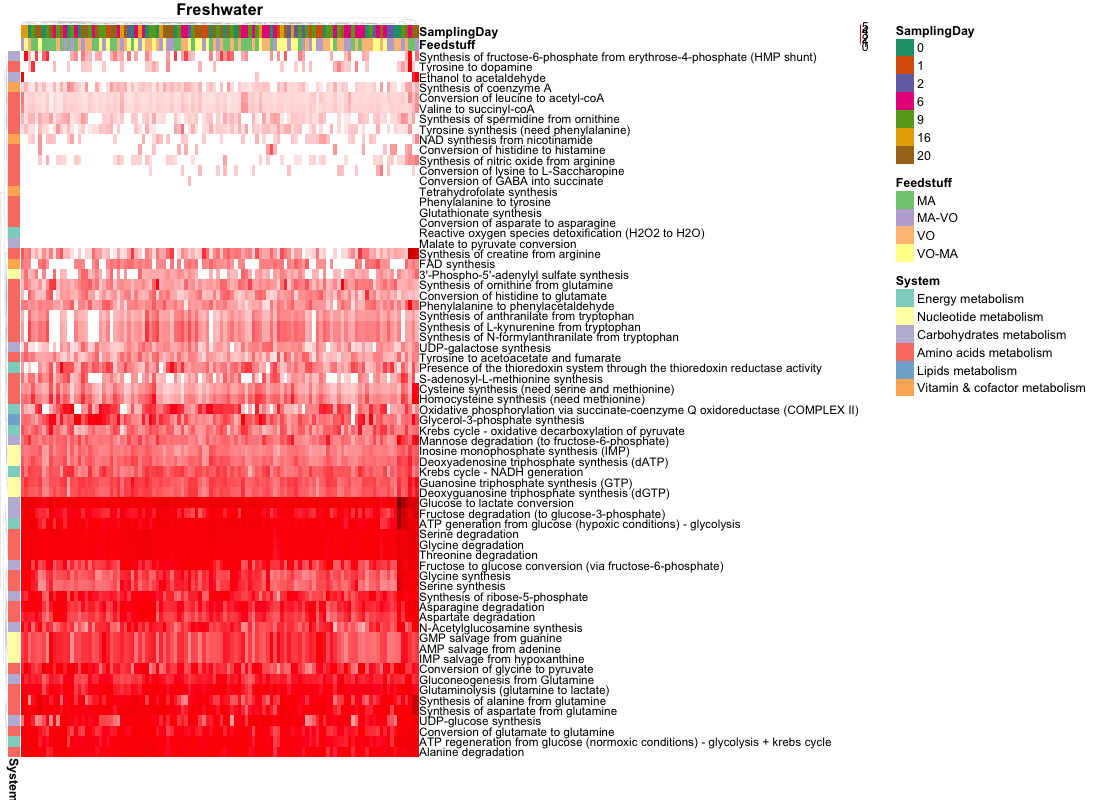

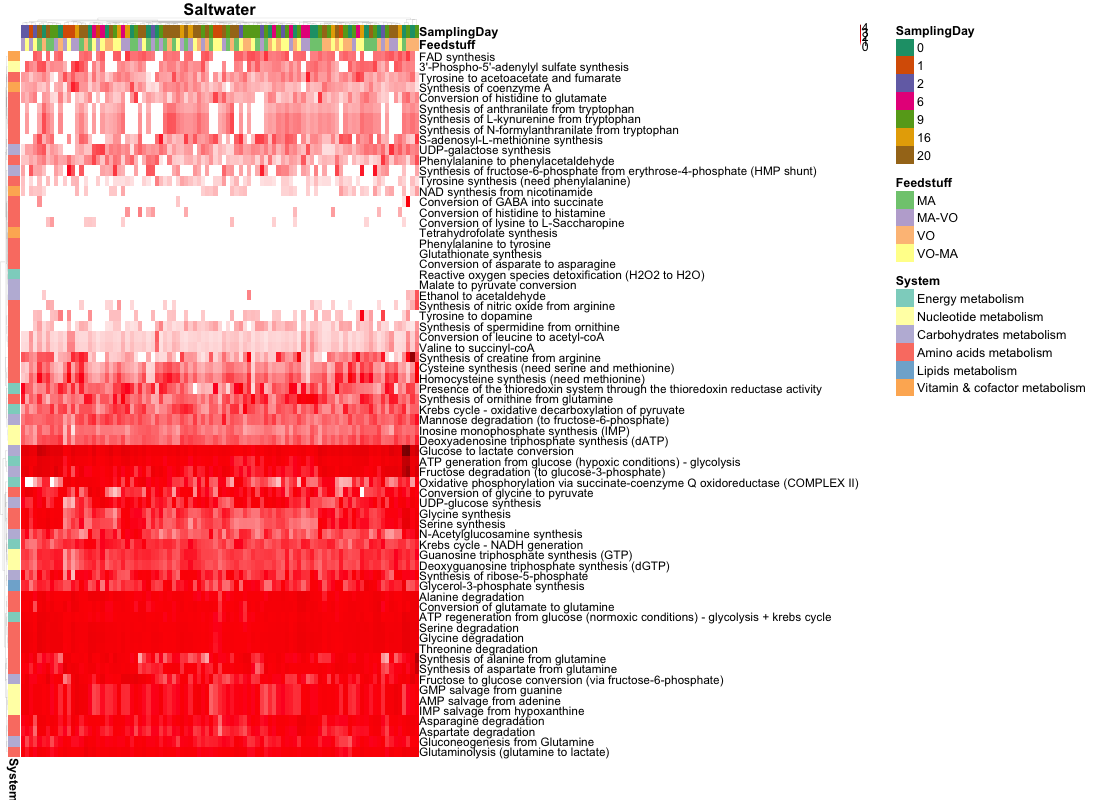

In [25]:
%%R -w 110 -h 80 --units in -r 10

# Set working directory
setwd('~/Git/msc-hm')

# Import needed modules

suppressMessages(
    paste(library(tidyverse),
    library(readxl),
    library(pheatmap), sep="")
)



# Read data files
df <- read.csv('MT_scores/sasa_GIMME.csv', 
               row.names = 1, check.names = FALSE)
df <- as.matrix(df)

meta <- read.table('salmon_feed_switch.sample_meta.txt')


suppressMessages(
    tasks <- read_excel('Tasks.xlsx') 
)
tasks <- filter(tasks, !is.na(ID)) %>% select(2:4)

# Separating into two dataframes, one for each lifestage, i.e. freshwater (fw), saltwater (sw)
idx <- which(meta$water[meta$sample %in% colnames(df)] == 'freshwater')

fw <- df[, idx]
sw <- df[, -idx]


###################################################################################
#                                                                                 #
#                                  Freshwater                                     #
#                                                                                 #
###################################################################################


# Get lifestage, feedstuff and system info in separate vectors
fw_feed <- meta$feed[meta$sample %in% colnames(fw)]


# Getting factor levels in a vector
days <- c()
for(i in 0:50){
  if(sum(str_detect(colnames(df), str_c('D', i))) != 0){
    days <- c(days, i)
  }
}

# Get sampling day, feedstuff and system info in separate vectors
fw_day <- factor(meta$day[meta$sample %in% colnames(fw)], 
              levels = as.character(days))


idx <- tasks$DESCRIPTION %in% rownames(fw)
fw_system <- tasks$SYSTEM[idx]
fw_system <- Hmisc::capitalize(str_to_lower(fw_system))


# Create dataframes with row and column annotation information
fw_row_annot <- data.frame('Feedstuff' = fw_feed, 'SamplingDay' = fw_day)
rownames(fw_row_annot) <- colnames(fw)

fw_col_annot <- data.frame('System' = fw_system)
rownames(fw_col_annot) <- rownames(fw)


# Create distinct colour palette for annotation of systems
fw_distinct_cols_system <- RColorBrewer::brewer.pal(
  length(unique(fw_system)), name='Set3')

fw_distinct_cols_day <- RColorBrewer::brewer.pal(
  length(unique(fw_day)), name = 'Dark2')

fw_distinct_cols_feed <- RColorBrewer::brewer.pal(
  length(unique(fw_feed)), name = 'Accent')



# Store annotation colours in list
fw_ann_colors = list(
  SamplingDay = setNames(fw_distinct_cols_day, levels(fw_day)),
  Feedstuff = setNames(fw_distinct_cols_feed, unique(fw_feed)),
  System = setNames(fw_distinct_cols_system, unique(fw_system))
)



# Plot the heatmap
pheatmap(fw, 
        color = colorRampPalette(c("white", "red1", "red2", "red3", "red4"))(500),
        cluster_rows = TRUE, 
        cluster_cols = TRUE, 
        show_rownames = TRUE, 
        show_colnames = FALSE, 
        annotation_col = fw_row_annot,
        annotation_row = fw_col_annot,
        annotation_colors = fw_ann_colors,
        display_numbers = FALSE,
        fontsize = 90,
        fontsize_row = 85,
        border_color = NA,
        main = "Freshwater")
        #silent = TRUE)


###################################################################################
#                                                                                 #
#                                  Saltwater                                      #
#                                                                                 #
###################################################################################



# Get lifestage, feedstuff and system info in separate vectors
sw_feed <- meta$feed[meta$sample %in% colnames(sw)]


# Get sampling day, feedstuff and system info in separate vectors
sw_day <- factor(meta$day[meta$sample %in% colnames(sw)], 
                 levels = as.character(days))


idx <- tasks$DESCRIPTION %in% rownames(sw)
sw_system <- tasks$SYSTEM[idx]
sw_system <- Hmisc::capitalize(str_to_lower(sw_system))



# Create dataframes with row and column annotation information
sw_row_annot <- data.frame('Feedstuff' = sw_feed, 'SamplingDay' = sw_day)
rownames(sw_row_annot) <- colnames(sw)

sw_col_annot <- data.frame('System' = sw_system)
rownames(sw_col_annot) <- rownames(sw)


# Create distinct colour palette for annotation of systems
sw_distinct_cols_system <- RColorBrewer::brewer.pal(
  length(unique(sw_system)), name='Set3')

sw_distinct_cols_day <- RColorBrewer::brewer.pal(
  length(unique(sw_day)), name = 'Dark2')

sw_distinct_cols_feed <- RColorBrewer::brewer.pal(
  length(unique(sw_feed)), name = 'Accent')



# Store annotation colours in list
sw_ann_colors = list(
  SamplingDay = setNames(sw_distinct_cols_day, levels(sw_day)),
  Feedstuff = setNames(sw_distinct_cols_feed, unique(sw_feed)),
  System = setNames(sw_distinct_cols_system, unique(sw_system))
)


# Plot the heatmap
pheatmap(sw, 
        color = colorRampPalette(c("white", "red1", "red2", "red3", "red4"))(500),
        cluster_rows = TRUE, 
        cluster_cols = TRUE, 
        show_rownames = TRUE, 
        show_colnames = FALSE, 
        annotation_col = sw_row_annot,
        annotation_row = sw_col_annot,
        annotation_colors = sw_ann_colors,
        display_numbers = FALSE,
        fontsize = 90,
        fontsize_row = 85,
        border_color = NA,
        main = "Saltwater")
        #silent = TRUE)